In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import csv
from util import *
import itertools
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import tensorflow as tf
import keras2.backend.tensorflow_backend as K
import gym2
from util import make_standup_agent
import copy

Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape, s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

def split_params(tw):
    action_tw = []
    tau_tw = []
    for i in range(len(tw)):
        if i % 4 < 2:
            action_tw.append(tw[i])
        else:
            tau_tw.append(tw[i])
    return action_tw, tau_tw

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th


In [5]:
actor = branch_actor((2,),(2,))

In [6]:
# set desiered actor
# actor = make_standup_agent(actor, .02, env, verbose=False)
actor.load_weights('./saved_agent/learned_self4_actor.h5')

In [45]:
# make memory with one stap interaction

memory_limit = 10000
memory = []
low = np.array([-10., 0.01])
high = np.array([10, 1.0])
for i in range(memory_limit):
    env.reset()
    reward = 0
    state0 = env.state
    a_agent, tau = np.random.uniform(low=low, high=high)
    tau = np.clip(tau, 0.01, 1.)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    state1 = env.state
    memory.append([state0, np.array([a_agent, tau]), reward, state1])
    print('\r' + f'{int(i*100/memory_limit)} %', end='')
memory = np.array(memory)

99 %

In [26]:
# make memory
# actionの分散が小さい
smemory = []
end_time = 10.
l = 1.
n_episodes = 300

for i in range(n_episodes):
    env.reset()
    episode_time = 0
    episode_memory = []
    while True:
        reward = 0
        state0 = env.state
        a_agent, tau = actor.predict_on_batch(np.array([[state0]]))[0]
        # tau += np.random.normal(0, 0.1)
        tau = np.clip(tau, 0.01, 1.)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        episode_time += tau
        # print(tau, dt, action_repetition)
        for p in range(action_repetition):
            _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - 0.01 * a_agent**2 + l * tau
        state1 = env.state
        episode_memory.append([state0, np.array([a_agent, tau]), reward, state1])
        if episode_time > end_time:
            break
    print('\r' + f'{int(i*100/n_episodes)} %', end='')
    smemory.append(np.array(episode_memory))

99 %

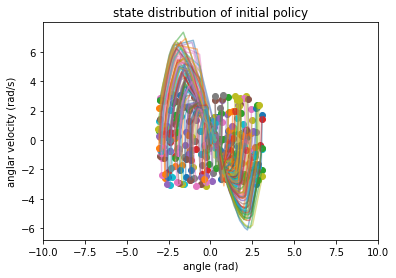

In [27]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, em in enumerate(smemory):
    em = np.array(em[:,0].tolist())
    # print(em.shape)
    plt.scatter(em[0,0], em[0,1], marker='o', color=cycle[i%10])
    plt.scatter(em[-1,0], em[-1,1], marker='x', color=cycle[i%10])
    plt.plot(em[:,0], em[:,1], color=cycle[i%10], label=f'{i} th episode', alpha=0.5)
plt.xlabel('angle (rad)')
plt.ylabel('anglar velocity (rad/s)')
plt.title('state distribution of initial policy')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim((-10,10))
plt.show()

In [43]:
# memory = np.array(list(itertools.chain.from_iterable(np.array(smemory))))
print(memory.shape)

(10000, 4)


(array([ 963.,  989., 1019.,  999., 1016., 1011., 1000.,  990., 1041.,
         972.]),
 array([-9.99925548e+00, -7.99937814e+00, -5.99950081e+00, -3.99962348e+00,
        -1.99974615e+00,  1.31177342e-04,  2.00000851e+00,  3.99988584e+00,
         5.99976317e+00,  7.99964050e+00,  9.99951783e+00]),
 <a list of 10 Patch objects>)

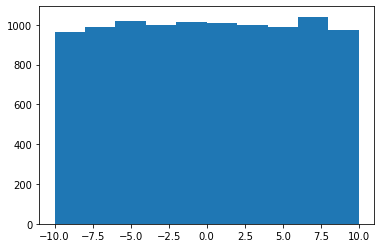

In [49]:
action_memory = np.array(memory[:,1].tolist())
plt.hist(action_memory[:,0])
# criticの学習として, actionの分散が少なすぎる

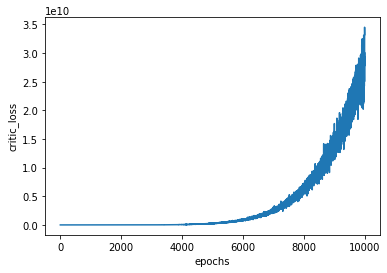

In [51]:
# critic learning
critic = critic_net((2,),(2,))[0]
critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
critic.load_weights('./saved_agent/learned_self4_critic.h5')
epoch = 10000
batch_size = 128
gamma = 0.99
arr = np.array(range(memory.shape[0]))
losses = []
for _ in range(epoch):
    # make mini_batch
    mem = memory[np.random.choice(arr, batch_size, replace=False)]
    state0_batch = []
    action_batch = []
    reward_batch = []
    state1_batch = []
    for m in mem:
        state0_batch.append([m[0]])
        action_batch.append(m[1])
        reward_batch.append([m[2]])
        state1_batch.append([m[3]])
    state0_batch, action_batch, reward_batch, state1_batch = \
    np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

    # TD error
    next_action = actor.predict_on_batch(state1_batch)
    state1_batch_with_action = [next_action, state1_batch]
    r_second = gamma * critic.predict_on_batch(state1_batch_with_action)
    r = reward_batch + r_second
    
    # learn
    critic_input_batch = [action_batch, state0_batch]
    loss = critic.train_on_batch(critic_input_batch, r)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [30]:
critic.save_weights('./saved_agent/learned_self4_critic_supervised2.h5')

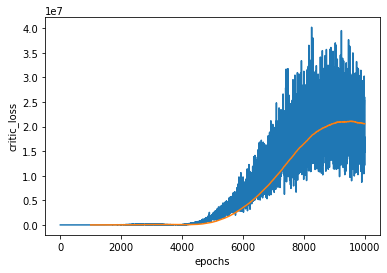

In [48]:
l = 1000
plt.plot(losses)
plt.plot(range(l, len(losses)), moving_average(losses,l))
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [ ]:
# 学習データを安定領域内のみに限定して, 同じデータセットにしても発散する
# ニューロンの数, 層の数を変えてもダメ -> 表現能力の問題ではない
# 当然, 学習データを1ステップづつ増やして, 学習を再現してもダメ

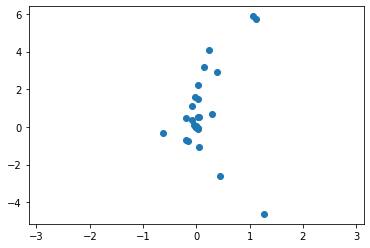

In [195]:
plt.scatter(np.array(state0_batch)[:,0,0], np.array(state0_batch)[:,0,1])
plt.xlim((-np.pi, np.pi))
plt.show()

(50, 2)


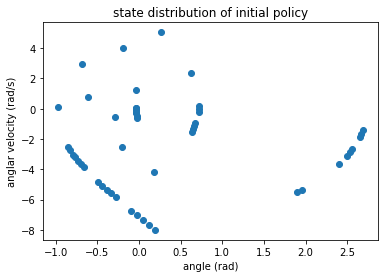

In [199]:
em = np.array(memory[:,0].tolist())[:50]
print(em.shape)
plt.scatter(em[:,0], em[:,1])

plt.xlabel('angle (rad)')
plt.ylabel('anglar velocity (rad/s)')
plt.title('state distribution of initial policy')
# plt.xlim((-10,10))
plt.show()

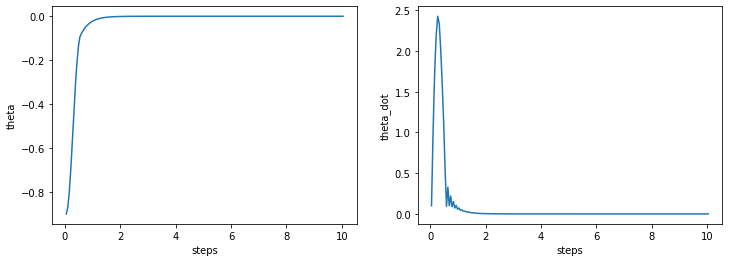

In [8]:
env.reset()
env.set_state(np.array([-0.9, 0.1]))
states = []
time_limit = 10
time_log = []
taus = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = actor.predict_on_batch(np.array([[x]]))[0]
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

## check policy gradient for fixed Q function

In [9]:
state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
actor_output = actor(state_input)
combined_input_tensor = [actor_output, state_input]
critic_output_tensor = learned_critic(combined_input_tensor)
loss = -K.mean(critic_output_tensor)
action_tw, tau_tw = split_params(actor.trainable_weights)

In [10]:
from keras2.optimizers import Optimizer

def calculate_gradient(target_func, params, state0_batch, combined_input_tensor):
    dummy_optimizer = Optimizer()
    gradient_tensors = dummy_optimizer.get_gradients(target_func, params)
    
    gradient_calculate_function = _gradient_calculate_function(combined_input_tensor, gradient_tensors)
    gradient_value = gradient_calculate_function([state0_batch])
    
    return gradient_value

def _gradient_calculate_function(combined_input_tensor, gradient_tensors):
    # function input
    input_tensors = [combined_input_tensor[1]]

    # tensorflow running function
    gradient_calculate_function = K.function(input_tensors, gradient_tensors)
    return gradient_calculate_function

def flatten_gradient(gradient_values):
    if len(gradient_values[0].shape) == 2:
        g_array = gradient_values[0].flatten()
    else:
        g_array = gradient_values[0]
    for g in gradient_values[1:]:
        if len(g.shape) == 2:
            g = g.flatten()
        g_array = np.hstack((g_array, g))
    return g_array

In [29]:
# state batch with policy depended distribution

states_batch = []
for i in range(500):
    env.reset()
    time_limit = 10
    acc_time = 0
    while True:
        x = env.state
        states_batch.append([x[0], x[1]])
        a_agent, tau = actor.predict_on_batch(np.array([[x]]))[0]
        action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        acc_time += tau
        for p in range(action_repetition):
            _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
        if acc_time > time_limit:
            break
    print('\r' + f'{i*2} %', end='')
states_batch = np.array(states_batch)
print()
print(states_batch.shape)

998 %
(5500, 2)


In [14]:
# batch gradient

# action_gradient for Q-function
action_gradient = calculate_gradient(loss, action_tw, states_batch, combined_input_tensor)
action_gradient_array = flatten_gradient(action_gradient)
print(action_gradient_array.shape, np.linalg.norm(action_gradient_array))
    
print()
# tau_gradient for Q-function
tau_gradient = calculate_gradient(loss, tau_tw, states_batch, combined_input_tensor)
tau_gradient_array = flatten_gradient(tau_gradient)
print(tau_gradient_array.shape, np.linalg.norm(tau_gradient_array))

(105,) 7.2692423

(105,) 0.086221896


In [11]:
# batch gradient

# action_gradient for actor_output
action_gradient_for_action = calculate_gradient(actor_output[:,0], action_tw, states_batch, combined_input_tensor)
action_output_gradient_array = flatten_gradient(action_gradient_for_action)
print(action_output_gradient_array.shape, np.linalg.norm(action_output_gradient_array))
    
print()
# tau_gradient for actor_output
tau_gradient_for_tau = calculate_gradient(actor_output[:,1], tau_tw, states_batch, combined_input_tensor)
tau_output_gradient_array = flatten_gradient(tau_gradient_for_tau)
print(tau_output_gradient_array.shape, np.linalg.norm(tau_output_gradient_array))

(105,) 5711284.5

(105,) 4.4364104


## $\frac{\partial Q}{\partial\mu}$ は保留

In [60]:
virtual_actor = tf.Variable([[1,0.001]])
virtual_critic_input = [virtual_actor, state_input]
virtual_critic_output = learned_critic(virtual_critic_input)
virtual_loss = -K.mean(virtual_critic_output)


In [62]:
gradient = calculate_gradient(virtual_loss, virtual_actor, states_batch, virtual_critic_input)
# ∂Q/∂a

# ∂Q/∂τ

InvalidArgumentError: All dimensions except 1 must match. Input 1 has shape [149281 2] and doesn't match input 0 with shape [1 2].
	 [[{{node gradients_4/model_2_10/concatenate_2/concat_grad/ConcatOffset}}]]

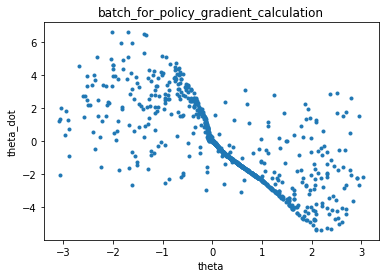

In [15]:
state_mini_batch = states_batch[np.random.choice(np.array(range(states_batch.shape[0])), 10000, replace=False)]
plt.scatter(state_mini_batch[:,0], state_mini_batch[:,1], marker='.')
plt.xlabel('theta')
plt.ylabel('theta_dot')
plt.title('batch_for_policy_gradient_calculation')
plt.show()

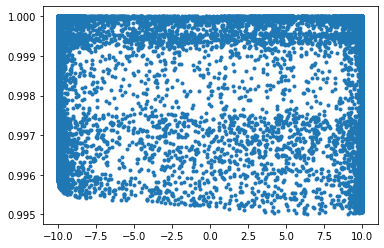

In [20]:
a = []
for m in memory[:,1]:
    a.append(m)
a = np.array(a)
plt.scatter(a[:,0], a[:,1], marker='.')

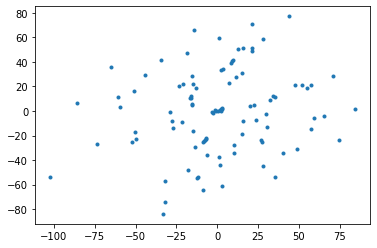

In [36]:
plt.scatter(states_batch[:100,0], states_batch[:100,1], marker='.')

tau = 0.001, actor set
memory_making
99 %
critic learn
gradient batch making
90 %
nabla_a = 9.393062591552734
nabla_tau = 7.300512606889242e-06
tau = 0.01, actor set
memory_making
99 %
critic learn
gradient batch making
99 %
nabla_a = 108.83155822753906
nabla_tau = 0.09803968667984009
tau = 0.02, actor set
memory_making
99 %
critic learn
gradient batch making
99 %
nabla_a = 5.213356018066406
nabla_tau = 0.09579192847013474
tau = 0.03, actor set
memory_making
99 %
critic learn
gradient batch making
99 %
nabla_a = 19.149776458740234
nabla_tau = 0.25868645310401917
tau = 0.04, actor set
memory_making
99 %
critic learn
gradient batch making
99 %
nabla_a = 8.681486129760742
nabla_tau = 0.02973250485956669
tau = 0.05, actor set
memory_making
99 %
critic learn
gradient batch making
99 %
nabla_a = 12.410390853881836
nabla_tau = 0.0037951068952679634
tau = 0.06, actor set
memory_making
99 %
critic learn
gradient batch making
99 %
nabla_a = 7.056506633758545
nabla_tau = 0.02095523662865162
tau =

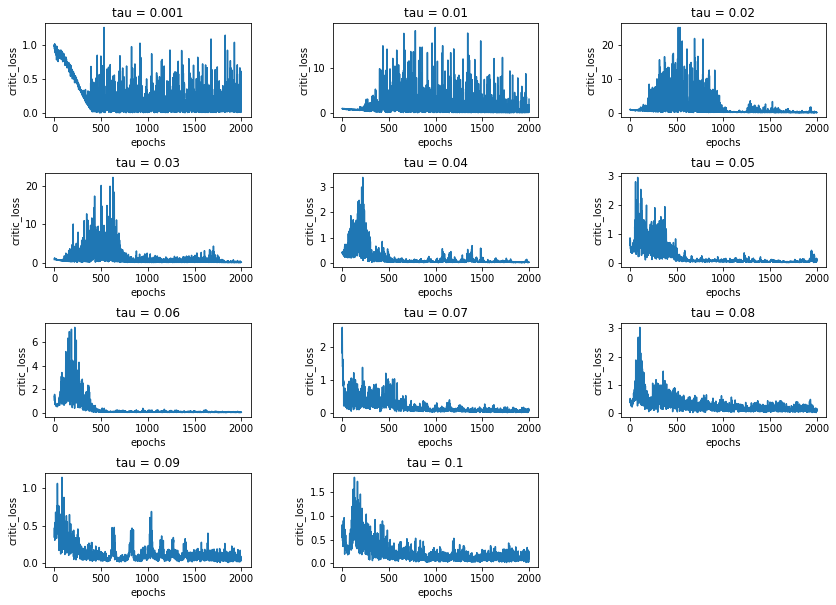

In [48]:
# many iteration
plt.figure(figsize=(14,10))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
norms = []
all_losses = []

for ite in range(11):
    s_tau = .01 * ite
    s_tau = np.clip(s_tau, 0.001, 0.1)
    print(f'tau = {s_tau}, actor set')
    actor = branch_actor((2,),(2,))
    actor = make_standup_agent(actor, s_tau, env)
    
    # make memory
    memory = []
    print('memory_making')
    l = 5.
    for i in range(50000):
        env.reset()
        reward = 0
        state0 = env.state
        a_agent, tau = actor.predict_on_batch(np.array([[state0]]))[0]
        action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        for p in range(action_repetition):
            _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - 0.01 * a_agent**2 + l * tau
        state1 = env.state
        memory.append([state0, np.array([a_agent, tau]), reward, state1])
        print('\r' + f'{int(i*.002)} %', end='')
    memory = np.array(memory)
    print()
    
    # critic learning
    print('critic learn')
    critic = critic_net((2,),(2,))[0]
    critic.compile(Adam(lr=0.001, clipnorm=1.), loss='mean_squared_error')
    epoch = 2000
    batch_size = 32
    gamma = 0.99
    arr = np.array(range(memory.shape[0]))
    losses = []
    for _ in range(epoch):
        # make mini_batch
        mem = memory[np.random.choice(arr, batch_size, replace=False)]
        state0_batch = []
        action_batch = []
        reward_batch = []
        state1_batch = []
        for m in mem:
            state0_batch.append([m[0]])
            action_batch.append(m[1])
            reward_batch.append([m[2]])
            state1_batch.append([m[3]])
        state0_batch, action_batch, reward_batch, state1_batch = \
        np.array(state0_batch), np.array(action_batch), np.array(reward_batch), np.array(state1_batch)

        # TD error
        next_action = actor.predict_on_batch(state1_batch)
        state1_batch_with_action = [next_action, state1_batch]
        r_second = gamma * critic.predict_on_batch(state1_batch_with_action)
        r = reward_batch + r_second

        # learn
        critic_input_batch = [action_batch, state0_batch]
        loss = critic.train_on_batch(critic_input_batch, r)
        losses.append(loss)
    plt.subplot(4,3,ite+1)
    plt.plot(losses)
    plt.xlabel('epochs')
    plt.ylabel('critic_loss')
    plt.title(f'tau = {s_tau}')
    
    all_losses.append(losses)
    
    # make tensor
    state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
    actor_output = actor(state_input)
    combined_input_tensor = [actor_output, state_input]
    critic_output_tensor = critic(combined_input_tensor)
    loss = -K.mean(critic_output_tensor)
    action_tw, tau_tw = split_params(actor.trainable_weights)
    
    # state batch with policy depended distribution

    states_batch = []
    time_limit = 10
    iters = int(time_limit / s_tau)
    n_episodes = int(100000 / iters)
    print('gradient batch making')
    for i in range(n_episodes):
        env.reset()
        acc_time = 0
        while True:
            x = env.state
            states_batch.append([rad_clip(x[0]), x[1]])
            a_agent, tau = actor.predict_on_batch(np.array([[x]]))[0]
            action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
            dt = tau / action_repetition
            acc_time += tau
            for p in range(action_repetition):
                _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
            if acc_time > time_limit:
                break
        print('\r' + f'{int(100*i/n_episodes)} %', end='')
    states_batch = np.array(states_batch)
    print()
    
    # batch gradient

    # action_gradient for Q-function
    action_gradient = calculate_gradient(loss, action_tw, states_batch, combined_input_tensor)
    action_gradient_array = flatten_gradient(action_gradient)
    print(f'nabla_a = {np.linalg.norm(action_gradient_array)}')

    # tau_gradient for Q-function
    tau_gradient = calculate_gradient(loss, tau_tw, states_batch, combined_input_tensor)
    tau_gradient_array = flatten_gradient(tau_gradient)
    print(f'nabla_tau = {np.linalg.norm(tau_gradient_array)}')
    norms.append([np.linalg.norm(action_gradient_array), np.linalg.norm(tau_gradient_array)])
    
plt.show()


In [55]:
norms = [[9.393062591552734, 7.300512606889242e-06],
         [108.83155822753906, 0.09803968667984009],
         [5.213356018066406, 0.09579192847013474],
         [19.149776458740234, 0.25868645310401917],
         [8.681486129760742, 0.02973250485956669],
         [12.410390853881836, 0.0037951068952679634],
         [7.056506633758545, 0.02095523662865162],
         [0.5677388906478882, 0.021662451326847076],
         [1.1467909812927246, 0.014824642799794674],
         [0.4321840703487396, 0.01271861046552658],
         [3.586627244949341, 0.0009824155131354928]
        ]
print(len(norms))

11


In [56]:
for ite in range(11):
    s_tau = .01 * ite
    s_tau = np.clip(s_tau, 0.001, 0.1)
    a, t = norms[ite]
    print(f'{s_tau}: nabla_a = {a}, nabla_tau = {t}')

0.001: nabla_a = 9.393062591552734, nabla_tau = 7.300512606889242e-06
0.01: nabla_a = 108.83155822753906, nabla_tau = 0.09803968667984009
0.02: nabla_a = 5.213356018066406, nabla_tau = 0.09579192847013474
0.03: nabla_a = 19.149776458740234, nabla_tau = 0.25868645310401917
0.04: nabla_a = 8.681486129760742, nabla_tau = 0.02973250485956669
0.05: nabla_a = 12.410390853881836, nabla_tau = 0.0037951068952679634
0.06: nabla_a = 7.056506633758545, nabla_tau = 0.02095523662865162
0.07: nabla_a = 0.5677388906478882, nabla_tau = 0.021662451326847076
0.08: nabla_a = 1.1467909812927246, nabla_tau = 0.014824642799794674
0.09: nabla_a = 0.4321840703487396, nabla_tau = 0.01271861046552658
0.1: nabla_a = 3.586627244949341, nabla_tau = 0.0009824155131354928
